In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob           # Allows to list out files within a directory
import os

import librosa                  # Working with audio
import librosa.display
import IPython.display as ipd   # Allows to play audio files in notebook

from itertools import cycle

from datasets import load_dataset
from librosa.feature import zero_crossing_rate

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [230]:
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

### Initial Audio Processing and Waveform Generation
To begin processing audio data, we first need to load the audio file into our Python environment. This is commonly done using libraries such as `librosa`, which provides convenient functions for audio analysis.

#### Steps
1. Import necessary libraries.
2. Load the audio files, returning the audio time series `y` and the sampling rate `sr`.
3. Visualise the waveform (time domain), plotting amplitude over time.
4. Convert and plot the frequency domain using Short-Time Fourier Transform to extract content.
5. Visualise with a spectrogram.

In [231]:
# Select Audio File and Play
i = 4000
ipd.Audio(ds[i])

In [232]:
y, sr = librosa.load(ds[i])

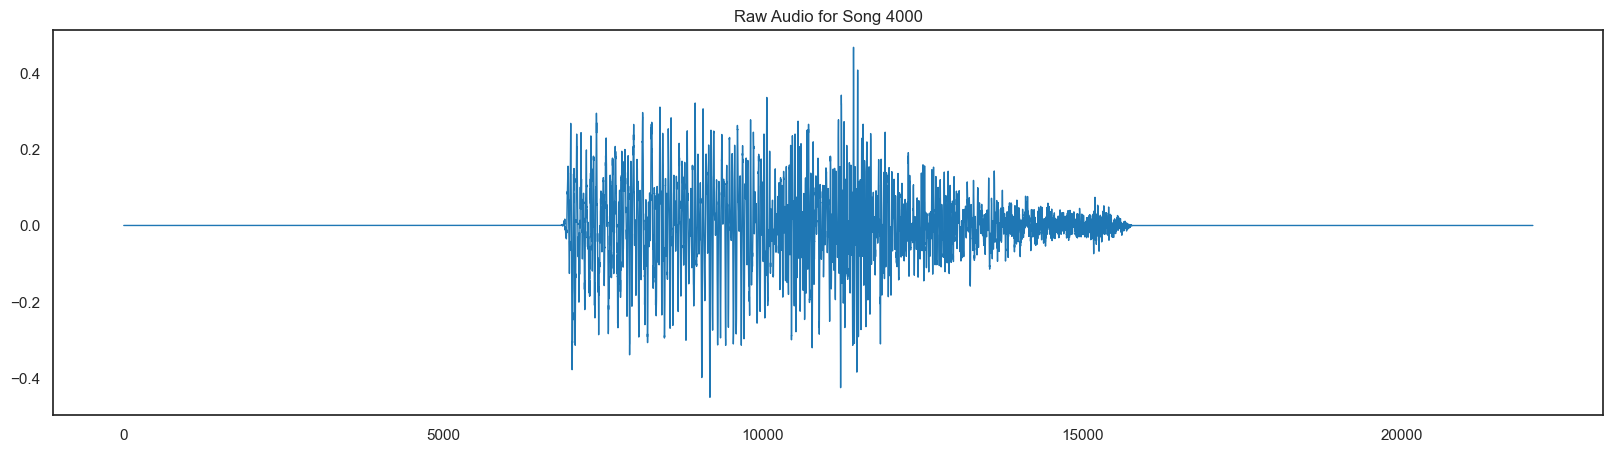

In [233]:
pd.Series(y).plot(figsize=(20, 5),
                  lw=1,
                  title=f"Raw Audio for Song {i}",
                  color=color_pal[0])
plt.show()

### Trimming Silence for Clean Visualisation
When visualizing or analyzing audio, it's important to reduce noise and silence to focus on the meaningful parts of the signal.

Trimming helps:
- Improve clarity of waveform/frequency plots.
- Speed up downstream processing (e.g., speech recognition).
- Focus on relevant audio segments (e.g., spoken words, music).

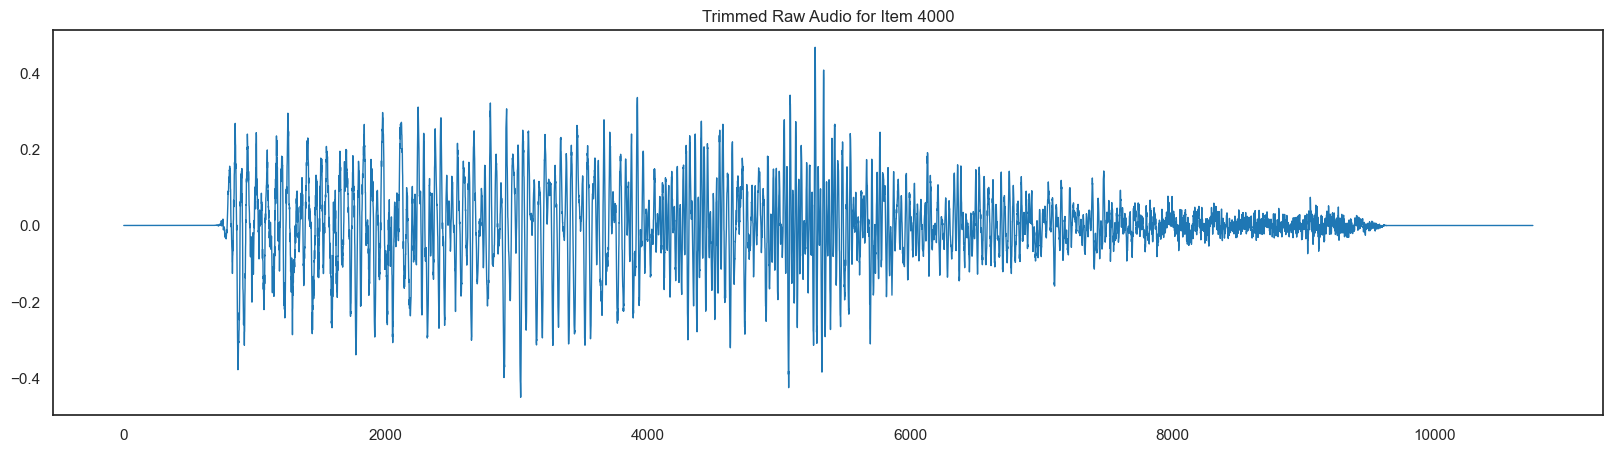

In [234]:
# Trimming Silence from Audio
y_trimmed, sr_trimmed = librosa.effects.trim(y, top_db=40)

pd.Series(y_trimmed).plot(figsize=(20, 5),
                  lw=1,
                  title=f"Trimmed Raw Audio for Item {i}",
                  color=color_pal[0])
plt.show()

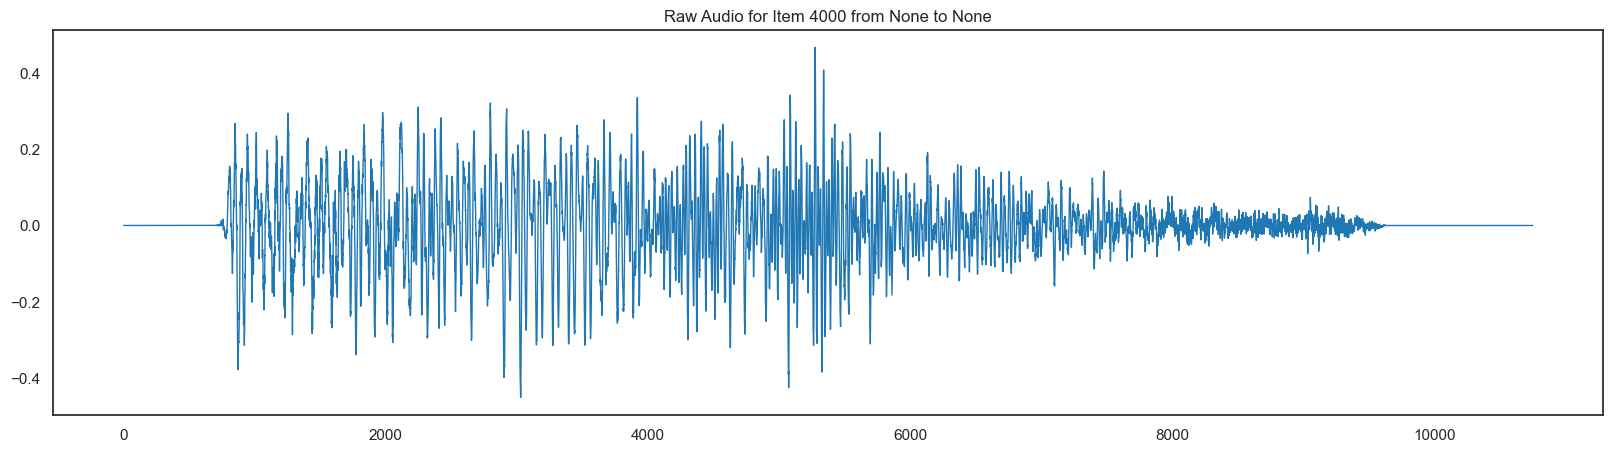

In [235]:
# Manual Trimming for Visualisation Purposes
start, end = None, None
pd.Series(y_trimmed[start:end]).plot(figsize=(20, 5),
                  lw=1,
                  title=f"Raw Audio for Item {i} from {start} to {end}",
                  color=color_pal[0])
plt.show()

In [236]:
# Method Determining Silence Ratio
def silence_ratio(time_series, threshold=0.01):
    rms = librosa.feature.rms(y=time_series)[0]
    silent_frames = np.sum(rms < threshold)
    return (silent_frames / rms.size)

In [237]:
# Visualisation Plotting Silence Ratio Before and After Trim
def compare_ratios(y1=y, y2=y_trimmed):
    # Obtain Ratios
    pre_trim, post_trim = silence_ratio(y1), silence_ratio(y2)

    plt.figure(figsize=(12, 6))
    # Before trimming
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y1, sr=sr)
    plt.title(f'Original Waveform (Silence Ratio: {pre_trim:.2%})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # After trimming
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(y2, sr=sr)
    plt.title(f'Trimmed Waveform (Silence Ratio: {post_trim:.2%})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

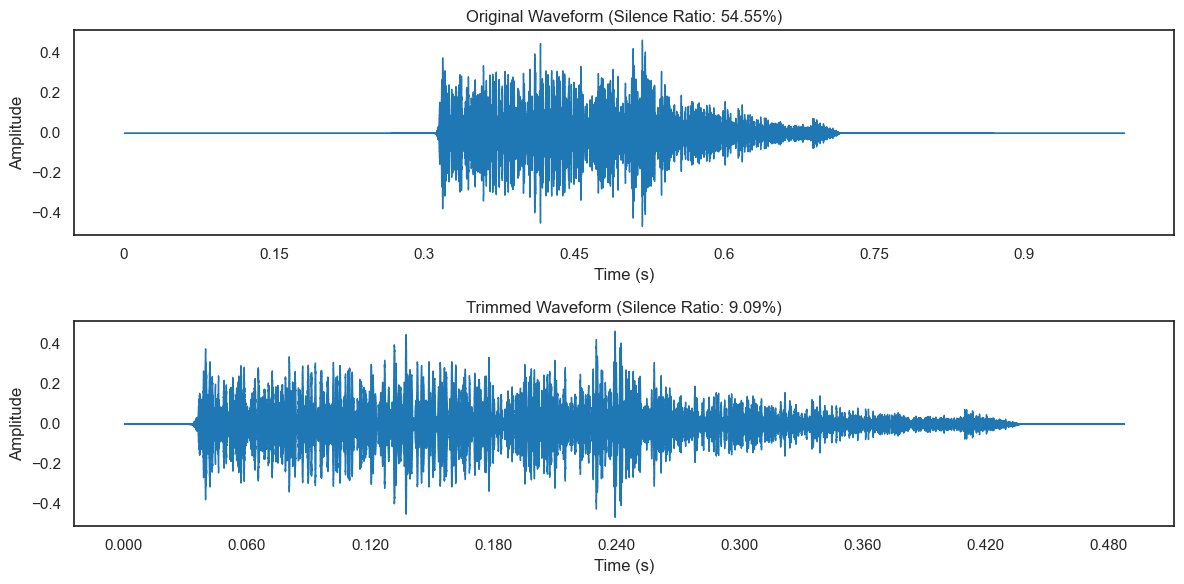

In [238]:
compare_ratios()

In [239]:
# Frequency Spectrum Visualisation
from scipy.fft import fft

def freq_spec(y1=y_trimmed):
    n = len(y1)
    frequencies = np.fft.fftfreq(n, d=1/sr)
    magnitudes = np.abs(fft(y1))

    plt.figure(figsize=(12, 4))
    plt.plot(frequencies[:n // 2], magnitudes[:n // 2])
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

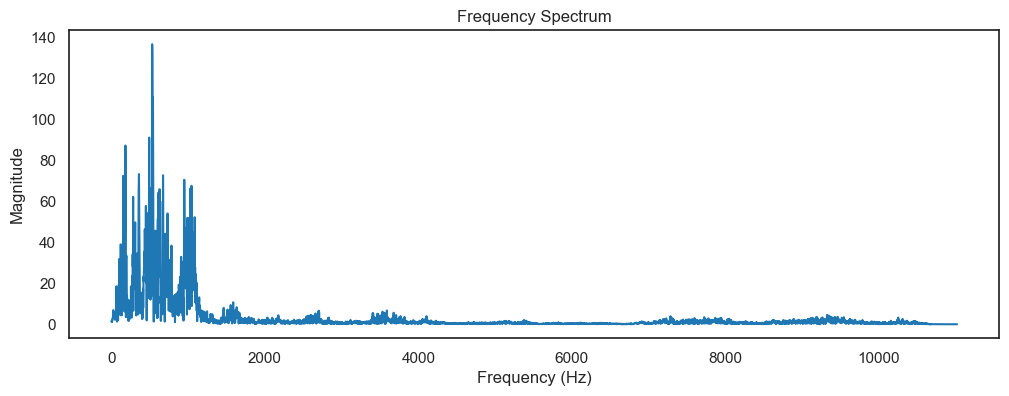

In [240]:
freq_spec()

In [241]:
# Spectrogram
def spectrogram(y1=y_trimmed):
    D = librosa.stft(y1)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(S_db,
                                   x_axis='time',
                                   y_axis='log',
                                   ax=ax)
    ax.set_title(f'Spectogram for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

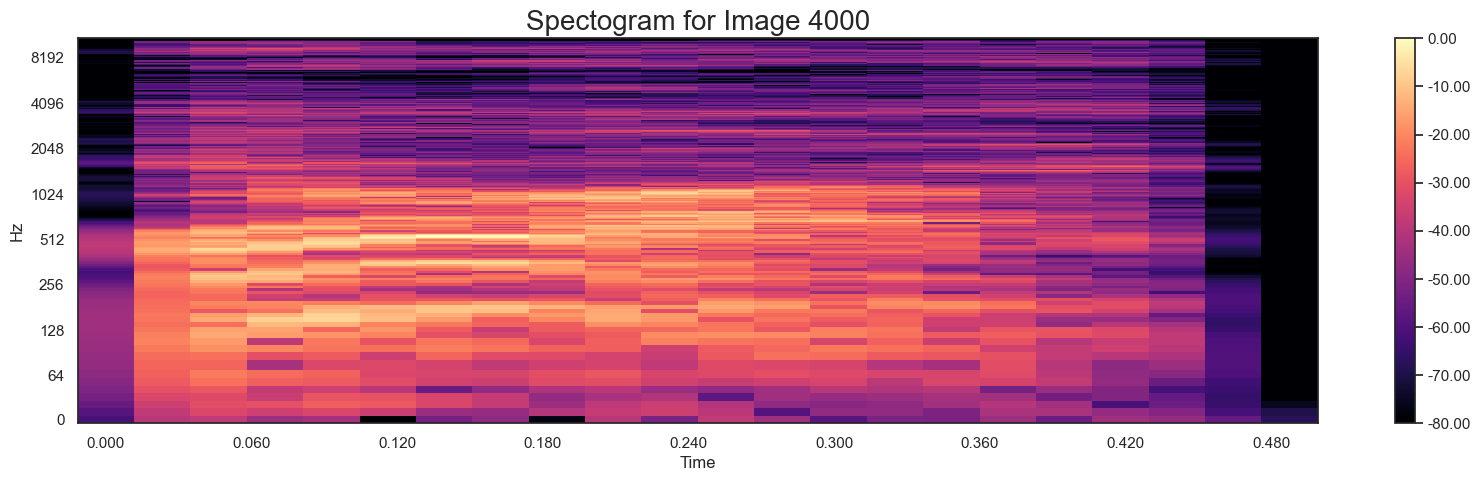

In [242]:
spectrogram()

In [243]:
# Mel Spectrogram
def mel_spec(y1=y_trimmed):
    S = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128, fmax=8000)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(S_db_mel,
                                   x_axis='time',
                                   y_axis='log',
                                   ax=ax)
    ax.set_title(f'Mel Spectogram for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

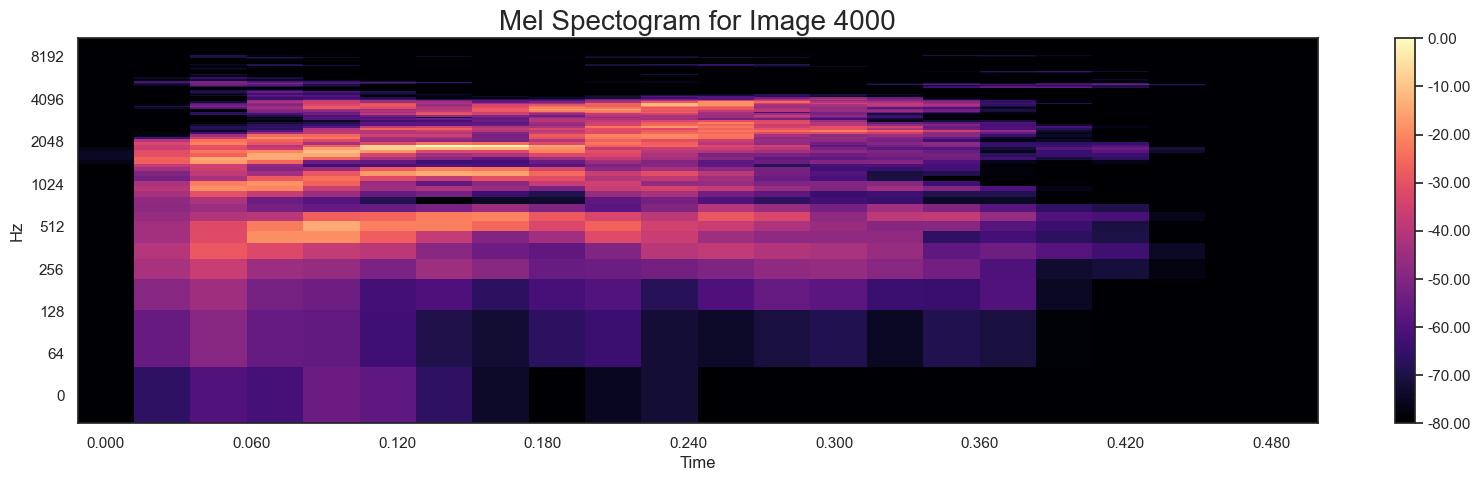

In [244]:
mel_spec()

In [245]:
def log_mel_spect(y1=y_trimmed):
    S = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel Spectrogram for Image {i}')
    plt.tight_layout()
    plt.show()

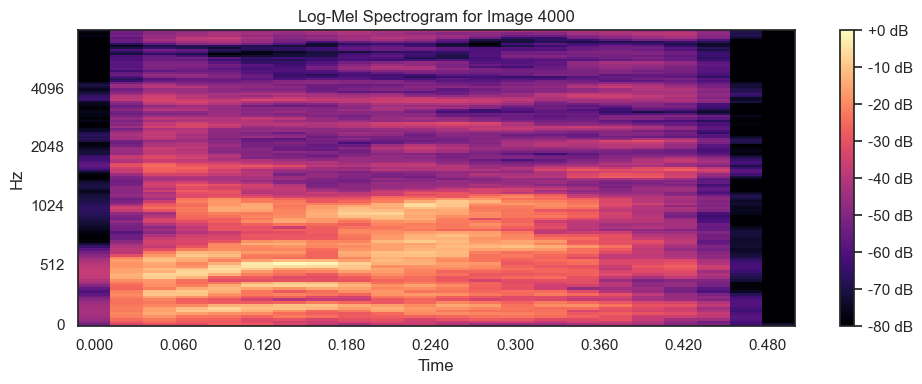

In [246]:
log_mel_spect()

In [247]:
# Mel Frequency Cepstral Coefficients (MFCCs)
def mfcc(y1=y_trimmed):
    mfcc = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=21, n_mels=256)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)

    ax.set_yticks(np.arange(0, mfcc.shape[0], 5))
    ax.set_yticklabels(np.arange(0, mfcc.shape[0], 5))

    ax.set_title(f'MFCCs for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_ylabel('MFCC Coefficient Index')
    ax.set_xlabel('Time (s)')
    plt.show()

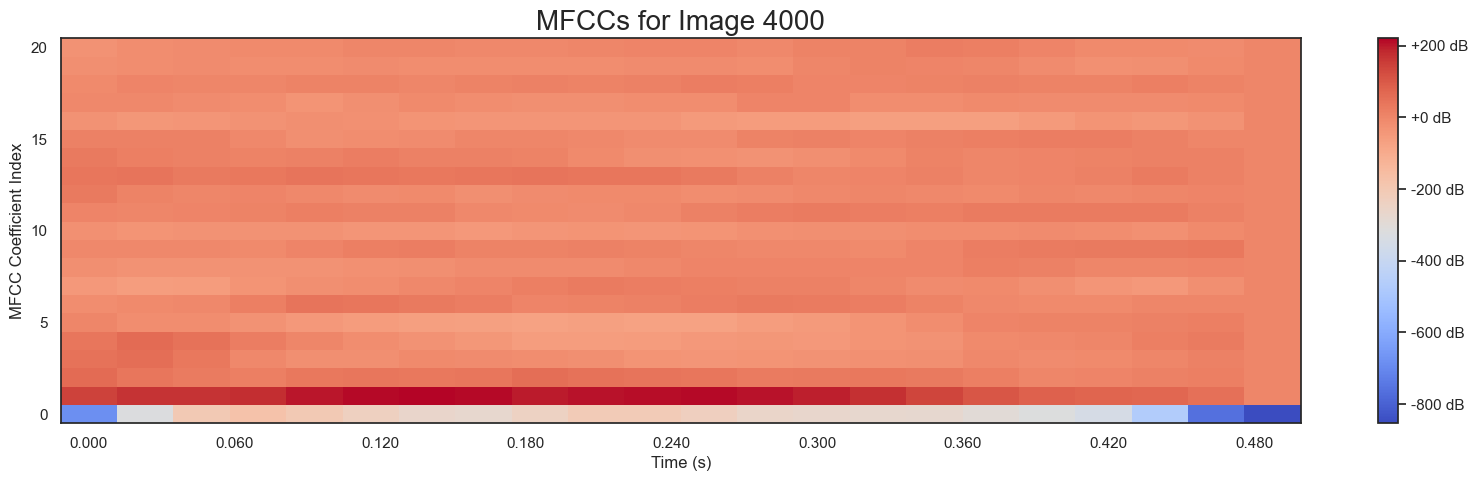

In [248]:
mfcc()

In [249]:
# Zero Crossing
def zero_crossing(y1=y_trimmed):
    # Calculate zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y1)
    frames = range(zcr.shape[1])  # Ensure you use the correct frame count
    times = librosa.frames_to_time(frames, sr=sr)

    # Plot ZCR
    plt.figure(figsize=(10, 4))
    plt.plot(times, zcr[0], label='ZCR')
    plt.title(f'Zero Crossing Rate Over Time for Image {i}', fontsize=16)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('ZCR', fontsize=12)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

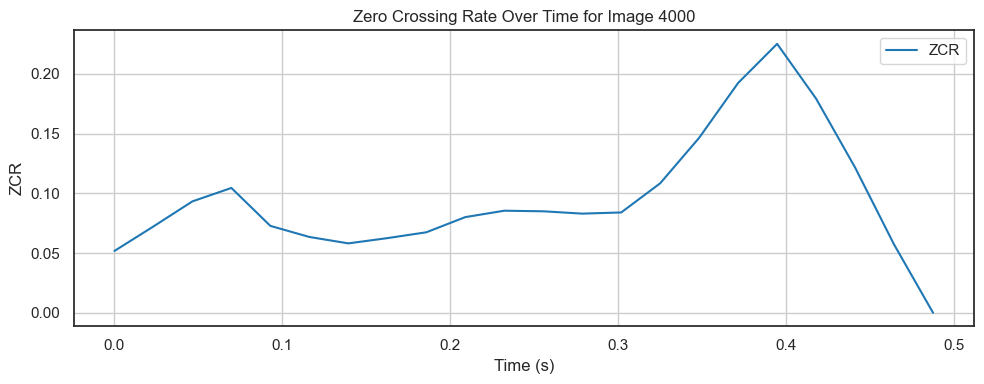

In [250]:
zero_crossing()

In [251]:
# Spectral Centroid
def spec_cent(y1=y_trimmed):
    centroids = librosa.feature.spectral_centroid(y=y1, sr=sr)[0]
    frames = range(len(centroids))
    t = librosa.frames_to_time(frames, sr=sr)

    plt.figure(figsize=(12, 6))
    librosa.display.waveshow(y1, sr=sr, alpha=0.4)
    plt.plot(t, centroids, color='b', label='Spectral Centroid')
    plt.title('Spectral Centroid Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude / Centroid')
    plt.legend()
    plt.show()

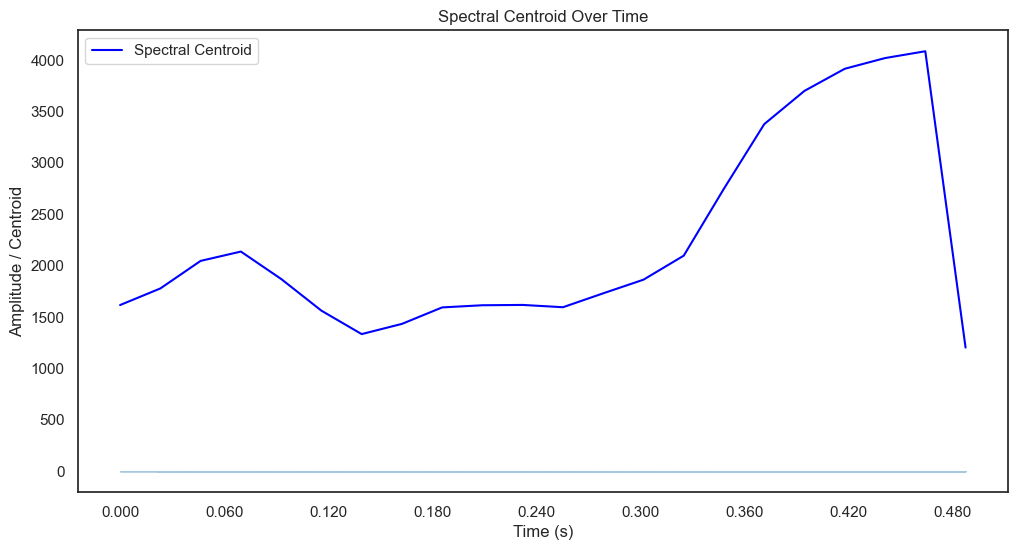

In [252]:
spec_cent()

In [253]:
# Constant-Q Transform (CQT)
def cqt(y1=y_trimmed):
    C = librosa.cqt(y=y1, sr=sr, n_bins=60, bins_per_octave=12, scale=False)
    C_db_mel = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(C_db_mel, x_axis='time', y_axis='cqt_note', ax=ax)
    ax.set_title(f'CQT for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=168
  warnings.warn(


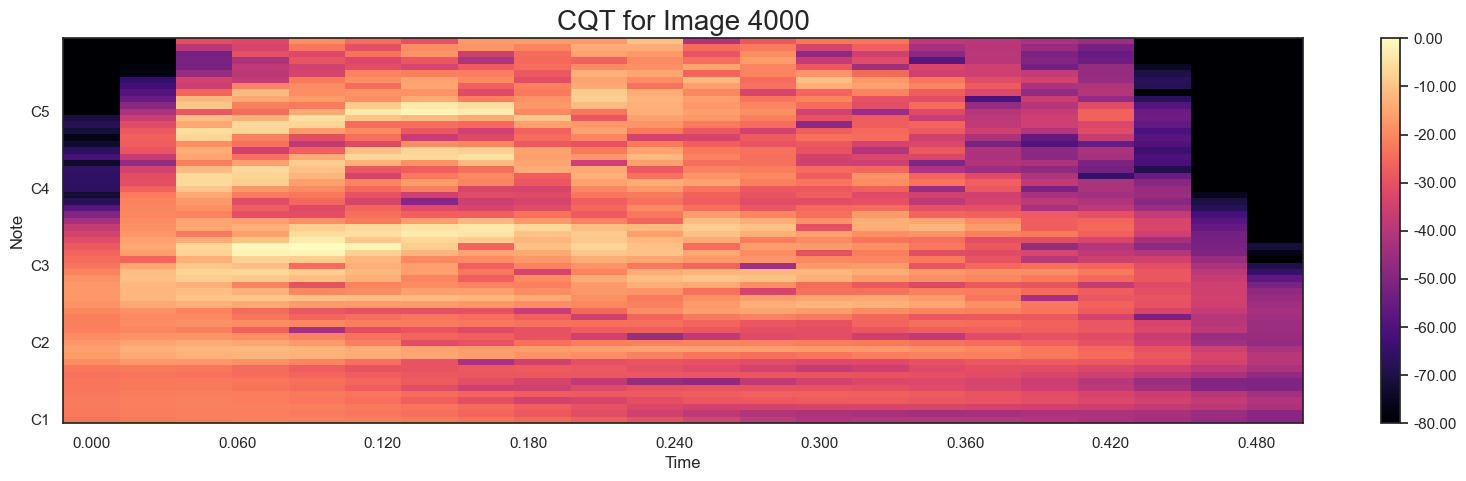

In [254]:
cqt()

In [255]:
# Construct Chroma Feature Visualization
def chroma_feature(y=y_trimmed):
    C = librosa.cqt(y=y_trimmed, sr=sr, n_bins=60, bins_per_octave=12, scale=False)
    chroma = librosa.feature.chroma_cqt(C=np.abs(C), sr=sr)

    fig, ax = plt.subplots(figsize=(20, 5))
    img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax)
    ax.set_title(f'Chroma for Image {i}', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

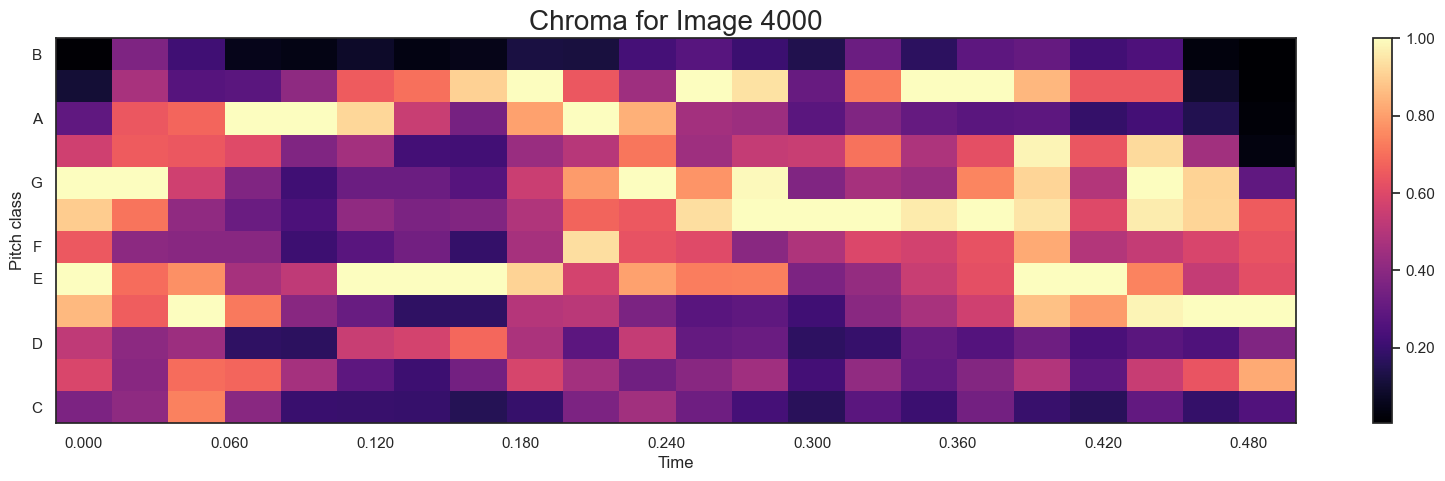

In [256]:
chroma_feature()